# MOOC Econometrics

## Test Exercise 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import f

import numpy as np

%matplotlib inline

In [2]:
from IPython.display import display, HTML

This test exercise is of an applied nature and uses data that are available in the data file `TestExer3`. 

### Taylor Rule

We consider the so-called Taylor rule for setting the (nominal) interest rate. This model describes the level of the nominal interest rate that the central bank sets as a function of equilibrium real interest rate and inflation, and considers the current level of inflation and production. 

Taylor (1993) considers the model:

$$i_t = r^* + \pi_t + 0.5 \, (\pi_t - \pi^*) + 0.5 \, g_t$$

where

- $i_t$ the Federal funds target interest rate at time $t$, 
- $r^∗$ the equilibrium real federal funds rate, 
- $\pi_t$ a measure of inflation, 
- $\pi^*$ the target inflation rate and 
- $g_t$ the output gap (how much actual output deviates from potential output). 

We simplify the Taylor rule in two manners: 

- First, we avoid determining $r^∗$ and $\pi^∗$ and simply add an intercept to the model to capture these two variables (and any other deviations in the means). 
- Second, we consider production $y_y$ rather than the output gap. 

In this form the Taylor rule is

$$i_t = \beta_1 + \beta_2 \pi_t + \beta_3 y_t + \varepsilon_t$$

### Data

Monthly data are available for the USA over the period 1960 through 2014 for the following variables:

- `INTRATE`: Federal funds interest rate
- `INFL`: Inflation
- `PROD`: Production
- `UNEMPL`: Unemployment
- `COMMPRI`: Commodity prices
- `PCE`: Personal consumption expenditure
- `PERSINC`: Personal income
- `HOUST`: Housing starts


In our variables, Taylor rule is

    INTRATE ~ const + INFL + PROD

In [3]:
data = pd.read_csv('TestExer 3-TaylorRule-round1.txt', sep='\t', 
                   thousands=',', decimal='.')
data = data.ix[:len(data)-2,0:9]
data.tail()

,OBS,INTRATE,INFL,PROD,UNEMPL,COMMPRI,PCE,PERSINC,HOUST
655,2014:8,0.09,1.7,4.4,2.0,7.4,4.4,1.5,8.8
656,2014:9,0.09,1.7,4.5,2.0,5.3,4.2,1.3,19.1
657,2014:10,0.09,1.7,4.4,2.0,-3.6,4.2,1.9,16.7
658,2014:11,0.09,1.3,5.2,2.1,-15.2,4.1,2.2,-5.6
659,2014:12,0.12,0.7,4.9,2.3,-28.0,3.6,3.0,5.3


### Questions

**(a)** Use general-to-specific to come to a model. Start by regressing the federal funds rate on the other 7 variables
and eliminate 1 variable at a time.

In [4]:
y = data.INTRATE
X = sm.add_constant(data.ix[:, 2:])
X.head()

,const,INFL,PROD,UNEMPL,COMMPRI,PCE,PERSINC,HOUST
0,1,1.2,10.0,3.4,8.0,5.7,1.7,-11.9
1,1,1.4,7.0,3.5,-8.6,5.1,1.3,-9.8
2,1,1.5,4.5,2.7,-16.8,5.6,0.9,-31.5
3,1,1.9,1.5,2.8,-5.0,7.8,0.7,-18.9
4,1,1.8,-0.1,1.7,-12.4,4.4,0.3,-15.2


In [5]:
full_model = sm.OLS(y, X).fit()
print 'model: INTRATE ~ ' + ' + '.join(X.columns)
pd.DataFrame({'$p$-value': full_model.pvalues.round(4), 
              '$\\beta$': full_model.params.round(4) })

model: INTRATE ~ const + INFL + PROD + UNEMPL + COMMPRI + PCE + PERSINC + HOUST


,$\beta$,$p$-value
const,-0.2147,0.3808
INFL,0.6968,0.0000
PROD,-0.0576,0.1489
UNEMPL,0.1041,0.2816
COMMPRI,-0.0055,0.0636
PCE,0.3426,0.0000
PERSINC,0.2464,0.0001
HOUST,-0.0194,0.0000


In [6]:
full_model.pvalues[1:].argmax()

'UNEMPL'

We look for least signigicant variable (expect for the intercept), which is `UNEMPL`, and remove it. Can automate it:

In [9]:
def backwards_elimination(y, X, stop=True):
    n, k = X.shape
    res = []
    aics = []
    bics = []
    r2s = []
    step = 0

    while k >= 2:
        display(HTML('Step %d, <b>$k=%d$</b>' % (step, k)))
        model = sm.OLS(y, X).fit()
        print 'model: INTRATE ~ ' + ' + '.join(X.columns)
        res.append(model.params.round(2))
        aics.append(model.aic)
        bics.append(model.bic)
        r2s.append(model.rsquared)

        coeffs = pd.DataFrame({'$p$-value': model.pvalues.round(4), 
                               '$\\beta$': model.params.round(4)})        
        display(coeffs)

        least_signigicant = model.pvalues[1:].argmax()
        if stop and model.pvalues[least_signigicant] <= 0.05:
            print 'all variables are significant'
            break
        
        print 'least significant predictor is', least_signigicant, 
        print '(p value is %0.4f)' % model.pvalues[least_signigicant]
        del X[least_signigicant]
        print

        k = k - 1
        step = step + 1

    print 
    display(HTML('<b>Lineage</b>'))
    display(pd.DataFrame(res).replace(np.nan,'-').T)
    
    plt.plot(aics, color='blue', label='AIC')
    plt.plot(bics, color='red', label='BIC')
    plt.xlabel('step')
    plt.legend()
    plt.show()
    
    plt.plot(r2s)
    plt.xlabel('step')
    plt.ylabel('$R^2$')
    plt.show()

model: INTRATE ~ const + INFL + PROD + UNEMPL + COMMPRI + PCE + PERSINC + HOUST


,$\beta$,$p$-value
const,-0.2147,0.3808
INFL,0.6968,0.0000
PROD,-0.0576,0.1489
UNEMPL,0.1041,0.2816
COMMPRI,-0.0055,0.0636
PCE,0.3426,0.0000
PERSINC,0.2464,0.0001
HOUST,-0.0194,0.0000


least significant predictor is UNEMPL (p value is 0.2816)



model: INTRATE ~ const + INFL + PROD + COMMPRI + PCE + PERSINC + HOUST


,$\beta$,$p$-value
const,-0.2856,0.2263
INFL,0.6942,0.0000
PROD,-0.0248,0.3357
COMMPRI,-0.0065,0.0209
PCE,0.3671,0.0000
PERSINC,0.2512,0.0000
HOUST,-0.0210,0.0000


least significant predictor is PROD (p value is 0.3357)



model: INTRATE ~ const + INFL + COMMPRI + PCE + PERSINC + HOUST


,$\beta$,$p$-value
const,-0.2363,0.3051
INFL,0.7177,0.0000
COMMPRI,-0.0075,0.0046
PCE,0.3398,0.0000
PERSINC,0.2402,0.0001
HOUST,-0.0205,0.0000


all variables are significant



,0,1,2
COMMPRI,-0.01,-0.01,-0.01
HOUST,-0.02,-0.02,-0.02
INFL,0.7,0.69,0.72
PCE,0.34,0.37,0.34
PERSINC,0.25,0.25,0.24
PROD,-0.06,-0.02,-
UNEMPL,0.1,-,-
const,-0.21,-0.29,-0.24


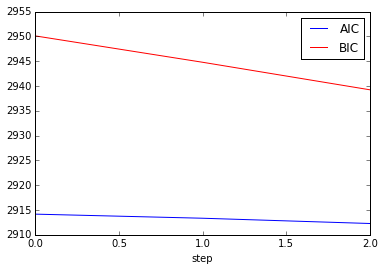

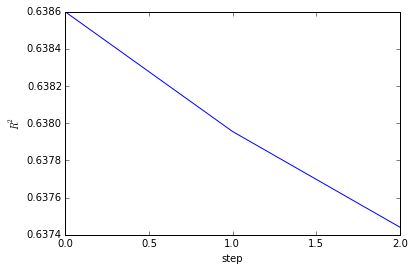

In [10]:
X = sm.add_constant(data.ix[:, 2:])
backwards_elimination(y, X)

Using $R^2$ and AIC, the best model is the full model (step 0), but according to BIC, the best model is model otained at step 2. I think the model at step 2 is better because it's less complex. So it's 

    INTRATE ~ const + INFL + COMMPRI + PCE + PERSINC + HOUST

**(b)** Use specific-to-general to come to a model. Start by regressing the federal funds rate on only a constant and
add 1 variable at a time. Is the model the same as in (a)?

In [11]:
def forwards_selection(y, X, stop=True):
    n, k = X.shape
    selected = ['const']
    
    res = []
    aics = []
    bics = []
    r2s = []

    while len(selected) < k:
        display(HTML('<b>$k=%d$</b>' % len(selected)))

        best_model = None
        best_val = None
        best_p = 1.0

        for unused in set(X.columns) - set(selected):
            model = sm.OLS(y, X.ix[:, selected + [unused]]).fit()
            if model.pvalues[unused] < best_p:
                best_model = model
                best_val = unused
                best_p = model.pvalues[unused]
        
        if stop and best_p >= 0.5:
            print 'no significant predictor was found'
            break
        
        print 'including %s with best p-value=%0.4f' % (best_val, best_p)
        selected.append(best_val)
        print 'model: INTRATE ~ ' + ' + '.join(selected)
        
        res.append(best_model.params.round(2))
        aics.append(best_model.aic)
        bics.append(best_model.bic)
        r2s.append(best_model.rsquared)

        coeffs = pd.DataFrame({'$p$-value': best_model.pvalues.round(4), 
                               '$\\beta$': best_model.params.round(4) })        
        display(coeffs)

    print 
    display(HTML('<b>Lineage</b>'))
    display(pd.DataFrame(res).replace(np.nan,'-').T)
    
    plt.plot(aics, color='blue', label='AIC')
    plt.plot(bics, color='red', label='BIC')
    plt.xlabel('step')
    plt.legend()
    plt.show()
    
    plt.plot(r2s)
    plt.xlabel('step')
    plt.ylabel('$R^2$')
    plt.show()

including INFL with best p-value=0.0000
model: INTRATE ~ const + INFL


,$\beta$,$p$-value
const,1.6441,0
INFL,0.9447,0


including PERSINC with best p-value=0.0000
model: INTRATE ~ const + INFL + PERSINC


,$\beta$,$p$-value
const,0.4507,0.0211
INFL,1.0115,0.0000
PERSINC,0.4354,0.0000


including PCE with best p-value=0.0007
model: INTRATE ~ const + INFL + PERSINC + PCE


,$\beta$,$p$-value
const,0.0234,0.9190
INFL,0.8745,0.0000
PERSINC,0.3045,0.0000
PCE,0.1816,0.0007


including HOUST with best p-value=0.0000
model: INTRATE ~ const + INFL + PERSINC + PCE + HOUST


,$\beta$,$p$-value
const,-0.2104,0.3633
INFL,0.7447,0.0000
PERSINC,0.2567,0.0000
PCE,0.3106,0.0000
HOUST,-0.0215,0.0000


including COMMPRI with best p-value=0.0046
model: INTRATE ~ const + INFL + PERSINC + PCE + HOUST + COMMPRI


,$\beta$,$p$-value
const,-0.2363,0.3051
INFL,0.7177,0.0000
PERSINC,0.2402,0.0001
PCE,0.3398,0.0000
HOUST,-0.0205,0.0000
COMMPRI,-0.0075,0.0046


including PROD with best p-value=0.3357
model: INTRATE ~ const + INFL + PERSINC + PCE + HOUST + COMMPRI + PROD


,$\beta$,$p$-value
const,-0.2856,0.2263
INFL,0.6942,0.0000
PERSINC,0.2512,0.0000
PCE,0.3671,0.0000
HOUST,-0.0210,0.0000
COMMPRI,-0.0065,0.0209
PROD,-0.0248,0.3357


including UNEMPL with best p-value=0.2816
model: INTRATE ~ const + INFL + PERSINC + PCE + HOUST + COMMPRI + PROD + UNEMPL


,$\beta$,$p$-value
const,-0.2147,0.3808
INFL,0.6968,0.0000
PERSINC,0.2464,0.0001
PCE,0.3426,0.0000
HOUST,-0.0194,0.0000
COMMPRI,-0.0055,0.0636
PROD,-0.0576,0.1489
UNEMPL,0.1041,0.2816


,0,1,2,3,4,5,6
COMMPRI,-,-,-,-,-0.01,-0.01,-0.01
HOUST,-,-,-,-0.02,-0.02,-0.02,-0.02
INFL,0.94,1.01,0.87,0.74,0.72,0.69,0.7
PCE,-,-,0.18,0.31,0.34,0.37,0.34
PERSINC,-,0.44,0.3,0.26,0.24,0.25,0.25
PROD,-,-,-,-,-,-0.02,-0.06
UNEMPL,-,-,-,-,-,-,0.1
const,1.64,0.45,0.02,-0.21,-0.24,-0.29,-0.21


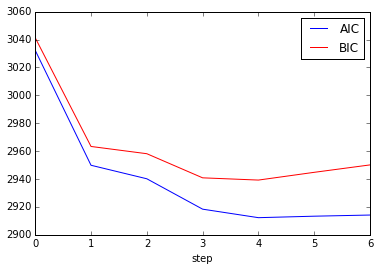

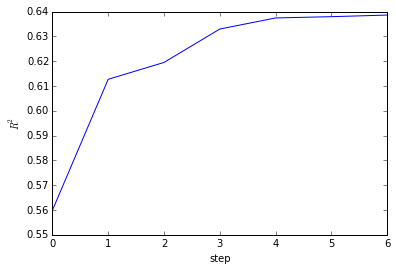

In [12]:
X = sm.add_constant(data.ix[:, 2:])
forwards_selection(y, X)

According to BIC criterion, the best model is obtained at step 4 (i.e. $k = 5$). This is the model:

    model: INTRATE ~ const + INFL + PERSINC + PCE + HOUST + COMMPRI


This is the same model as selected in **(a)** using BIC

**(c)** Compare your model from (a) and the Taylor rule of equation (1). Consider $R^2$, AIC and BIC. Which of the
models do you prefer?

Taylor rule:

    INTRATE ~ const + INFL + PROD

Model from **(a)**

    INTRATE ~ const + INFL + COMMPRI + PCE + PERSINC + HOUST
    

In [13]:
X = sm.add_constant(data.ix[:, 2:])
full_model = sm.OLS(y, X[['const', 'INFL', 'COMMPRI', 'PCE', 'PERSINC', 'HOUST']]).fit()
taylor_model = sm.OLS(y, X[['const', 'INFL', 'PROD']]).fit()

In [14]:
df = pd.DataFrame({'AIC': [full_model.aic, taylor_model.aic], 
                   'BIC': [full_model.bic, taylor_model.bic], 
                   '$R^2$': [full_model.rsquared, taylor_model.rsquared]})
df.index = ['(a)', 'Taylor']
df

,$R^2$,AIC,BIC
(a),0.637441,2912.277703,2939.231142
Taylor,0.574828,3011.420623,3024.897343


Full model is better at everything: it has higher $R^2$ and lower AIC and BIC.

**(d)** Test the Taylor rule of equation (1) using the RESET test, Chow break and forecast test (with in both tests as
break date January 1985) and a Jarque-Bera test. 

**RESET**

In [15]:
X_subset = pd.DataFrame(X[['const', 'INFL', 'PROD']])
taylor_model = sm.OLS(y, X_subset).fit()
X_subset['Fitted'] = taylor_model.fittedvalues ** 2

In [16]:
reset_model = sm.OLS(y, X_subset).fit()
pd.DataFrame({'$p$-value': reset_model.pvalues.round(4), 
              '$\\beta$': reset_model.params.round(4)})

,$\beta$,$p$-value
const,0.9826,0.0001
INFL,1.1668,0.0000
PROD,0.1000,0.0000
Fitted,-0.0139,0.1070


$t$-Test shows that the fitted value is not significant

Let's also calculate the $F$ statistic (which should result in be the same $p$-value):

In [17]:
S_0 = np.sum(taylor_model.resid ** 2)
S_1 = np.sum(reset_model.resid ** 2)

n = len(X)
k = 3 # const, INFL, PROD
p = 1 # include only quadratic term
F = ((S_0 - S_1) / p) / (S_1 / (n - k - p))
F

2.605275184570711

In [18]:
1 - f.cdf(F, p, n - k - p)

0.10698954356465185

So, again, we see that it's not significant. This means that we don't need to include quadratic terms (and cross-terms) into our model.

**Chow break** and **Chow forecast** (break in 01.1985)

In [19]:
X_subset = pd.DataFrame(X[['const', 'INFL', 'PROD']])
idx = np.where(data.OBS == '1985:1')[0][0]

y1 = y.ix[:idx]
X1 = X_subset.ix[:idx]

y2 = y.ix[idx:]
X2 = X_subset.ix[idx:]

In [20]:
full   = sm.OLS(y, X_subset).fit()
model1 = sm.OLS(y1, X1).fit()
model2 = sm.OLS(y2, X2).fit()

S0 = np.sum(full.resid ** 2)
S1 = np.sum(model1.resid ** 2)
S2 = np.sum(model2.resid ** 2)

Chow Break:

In [21]:
n = len(X_subset)
k = 3

F = ((S0 - S1 - S2) / k) / ((S1 + S2) / (n - 2*k))
F

5.498518462102

In [22]:
1 - f.cdf(F, k, n - 2*k)

0.00098260249843939995

It is significant: so we reject $H_0$ that there's no break point

Chow Forecast:

In [23]:
n2 = len(X2)
n1 = n - n2
F = ((S0 - S1) / n2) / (S1 / (n1 - k))
F

0.8888446255369153

In [24]:
1 - f.cdf(F, n2, n1 - k)

0.85709178941265163

Under $H_0$ we assume that all extra variables (gammas) in the second model are insignificant, i.e. what we learned from the first subset can be used to forecast values in the second.

Because the $p$-value is very large, we fail to reject $H_0$

**Jarque-Bera test**

In [25]:
full = sm.OLS(y, X_subset).fit()
full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                INTRATE   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     444.1
Date:                Wed, 18 Nov 2015   Prob (F-statistic):          9.63e-123
Time:                        22:47:03   Log-Likelihood:                -1502.7
No. Observations:                 660   AIC:                             3011.
Df Residuals:                     657   BIC:                             3025.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2507      0.176      7.103      0.000         0.905     1.597
INFL           0.9744      0.033     29.792      0.000         0.910     1.039
PROD           0.0948      0.020      4.810      0.000         0.056     0.133
==============================================================================
Omnibus:                       11.982   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.106
Skew:                           0.321   Prob(JB):                      0.00235
Kurtosis:                       3.164   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, $JB = 12.106$ (see last table) and $p$-value is $p=0.00235$, thus we fail to reject the $H_0$ of normality of residuals. This means that the model specification can be improved further.